In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import cross_val_score

In [2]:
londo_df = pd.read_parquet('Data/Bus station analysis/burglary.parquet')
londo_df.head(5)

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
29,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.140619,51.583427,On or near Rams Grove,E01000027,Barking and Dagenham 001A,Burglary,None,NaN
47,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.128479,51.583414,On or near Cavalier Close,E01000028,Barking and Dagenham 001B,Burglary,None,NaN
60,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.134801,51.578470,On or near Portland Close,E01000029,Barking and Dagenham 001C,Burglary,None,NaN
61,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.131156,51.582323,On or near Lake Road,E01000029,Barking and Dagenham 001C,Burglary,None,NaN
84,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.140466,51.584159,On or near Bagleys Spring,E01000030,Barking and Dagenham 001D,Burglary,None,NaN


In [3]:
# Define the columns to drop
columns_to_drop = ['Context', 'Reported by', 'Falls within', 'Location', 'Crime type', 'Crime ID', 'Last outcome category', 'Longitude', 'Latitude', 'LSOA code']

# Drop the columns
londo_df = londo_df.drop(columns=columns_to_drop)
londo_df.head(5)

,Month,LSOA name
29,2010-12,Barking and Dagenham 001A
47,2010-12,Barking and Dagenham 001B
60,2010-12,Barking and Dagenham 001C
61,2010-12,Barking and Dagenham 001C
84,2010-12,Barking and Dagenham 001D


In [4]:
# Drop rows with missing values in 'LSOA name'
londo_df = londo_df.dropna(subset=['LSOA name'])

In [5]:
# Extract month and year
londo_df['Month'] = pd.to_datetime(londo_df['Month'])
londo_df['Year'] = londo_df['Month'].dt.year  # Extract year
londo_df['Month'] = londo_df['Month'].dt.month  # Extract month 

londo_df.head(5)

,Month,LSOA name,Year
29,12,Barking and Dagenham 001A,2010
47,12,Barking and Dagenham 001B,2010
60,12,Barking and Dagenham 001C,2010
61,12,Barking and Dagenham 001C,2010
84,12,Barking and Dagenham 001D,2010


In [6]:
# Filter rows where 'LSOA name' ends with 'Barnet'
Barnet_df = londo_df[londo_df['LSOA name'].str.contains('Barnet')]

Barnet_df

,Month,LSOA name,Year
2051,12,Barnet 001A,2010
2052,12,Barnet 001A,2010
2053,12,Barnet 001A,2010
2054,12,Barnet 001A,2010
2071,12,Barnet 001B,2010
...,...,...,...
12908507,3,Barnet 041B,2023
12908508,3,Barnet 041B,2023
12908520,3,Barnet 041C,2023
12908521,3,Barnet 041C,2023


In [7]:
# Grouping by year and month and counting the rows in each group
grouped = Barnet_df.groupby(['Year', 'Month']).size().reset_index(name='Count')

# Converting the result to a DataFrame
grouped_df = pd.DataFrame(grouped)

grouped_df.head(20)

,Year,Month,Count
0,2010,12,372
1,2011,1,486
2,2011,2,403
3,2011,3,408
4,2011,4,414
5,2011,5,435
6,2011,6,411
7,2011,7,380
8,2011,8,355
9,2011,9,305


In [8]:
# Create a DataFrame with the missing months and a count of 0
missing_months = pd.DataFrame({'Year': [2023]*9, 'Month': range(4, 13), 'Count': [0]*9})

# Concatenate the original DataFrame with the missing months DataFrame
grouped_df = pd.concat([grouped_df, missing_months], ignore_index=True)

# Print the updated DataFrame
grouped_df.tail(15)

,Year,Month,Count
140,2022,10,248
141,2022,11,246
142,2022,12,228
143,2023,1,242
144,2023,2,199
145,2023,3,231
146,2023,4,0
147,2023,5,0
148,2023,6,0
149,2023,7,0


In [9]:
# Drop rows with year before 2010 or year 2023 and months after 3 (excluding December 2010)
grouped_df = grouped_df.loc[~(((grouped_df['Year'] == 2010) & (grouped_df['Month'] < 12)) | ((grouped_df['Year'] == 2023) & (grouped_df['Month'] > 5)))]
grouped_df

,Year,Month,Count
0,2010,12,372
1,2011,1,486
2,2011,2,403
3,2011,3,408
4,2011,4,414
...,...,...,...
143,2023,1,242
144,2023,2,199
145,2023,3,231
146,2023,4,0


In [10]:
# Define the number of lags
num_lags = 15

# Create lagged count columns
for lag in range(1, num_lags + 1):
    grouped_df[f'Count_lag_{lag}'] = grouped_df['Count'].shift(lag)

# Drop rows with missing values (due to the lags)
grouped_df.dropna(inplace=True)

# Reset the index of the DataFrame
grouped_df.reset_index(drop=True, inplace=True)

# Printing the updated DataFrame
grouped_df

,Year,Month,Count,Count_lag_1,Count_lag_2,Count_lag_3,Count_lag_4,Count_lag_5,Count_lag_6,Count_lag_7,Count_lag_8,Count_lag_9,Count_lag_10,Count_lag_11,Count_lag_12,Count_lag_13,Count_lag_14,Count_lag_15
0,2012,3,432,424.0,437.0,439.0,433.0,390.0,305.0,355.0,380.0,411.0,435.0,414.0,408.0,403.0,486.0,372.0
1,2012,4,310,432.0,424.0,437.0,439.0,433.0,390.0,305.0,355.0,380.0,411.0,435.0,414.0,408.0,403.0,486.0
2,2012,5,349,310.0,432.0,424.0,437.0,439.0,433.0,390.0,305.0,355.0,380.0,411.0,435.0,414.0,408.0,403.0
3,2012,6,438,349.0,310.0,432.0,424.0,437.0,439.0,433.0,390.0,305.0,355.0,380.0,411.0,435.0,414.0,408.0
4,2012,7,335,438.0,349.0,310.0,432.0,424.0,437.0,439.0,433.0,390.0,305.0,355.0,380.0,411.0,435.0,414.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,2023,1,242,228.0,246.0,248.0,189.0,171.0,190.0,195.0,218.0,171.0,218.0,202.0,243.0,199.0,219.0,213.0
129,2023,2,199,242.0,228.0,246.0,248.0,189.0,171.0,190.0,195.0,218.0,171.0,218.0,202.0,243.0,199.0,219.0
130,2023,3,231,199.0,242.0,228.0,246.0,248.0,189.0,171.0,190.0,195.0,218.0,171.0,218.0,202.0,243.0,199.0
131,2023,4,0,231.0,199.0,242.0,228.0,246.0,248.0,189.0,171.0,190.0,195.0,218.0,171.0,218.0,202.0,243.0


In [11]:
grouped_df.tail(15)

,Year,Month,Count,Count_lag_1,Count_lag_2,Count_lag_3,Count_lag_4,Count_lag_5,Count_lag_6,Count_lag_7,Count_lag_8,Count_lag_9,Count_lag_10,Count_lag_11,Count_lag_12,Count_lag_13,Count_lag_14,Count_lag_15
118,2022,3,218,202.0,243.0,199.0,219.0,213.0,178.0,165.0,155.0,187.0,151.0,202.0,272.0,185.0,193.0,212.0
119,2022,4,171,218.0,202.0,243.0,199.0,219.0,213.0,178.0,165.0,155.0,187.0,151.0,202.0,272.0,185.0,193.0
120,2022,5,218,171.0,218.0,202.0,243.0,199.0,219.0,213.0,178.0,165.0,155.0,187.0,151.0,202.0,272.0,185.0
121,2022,6,195,218.0,171.0,218.0,202.0,243.0,199.0,219.0,213.0,178.0,165.0,155.0,187.0,151.0,202.0,272.0
122,2022,7,190,195.0,218.0,171.0,218.0,202.0,243.0,199.0,219.0,213.0,178.0,165.0,155.0,187.0,151.0,202.0
123,2022,8,171,190.0,195.0,218.0,171.0,218.0,202.0,243.0,199.0,219.0,213.0,178.0,165.0,155.0,187.0,151.0
124,2022,9,189,171.0,190.0,195.0,218.0,171.0,218.0,202.0,243.0,199.0,219.0,213.0,178.0,165.0,155.0,187.0
125,2022,10,248,189.0,171.0,190.0,195.0,218.0,171.0,218.0,202.0,243.0,199.0,219.0,213.0,178.0,165.0,155.0
126,2022,11,246,248.0,189.0,171.0,190.0,195.0,218.0,171.0,218.0,202.0,243.0,199.0,219.0,213.0,178.0,165.0
127,2022,12,228,246.0,248.0,189.0,171.0,190.0,195.0,218.0,171.0,218.0,202.0,243.0,199.0,219.0,213.0,178.0


In [12]:
prediction_df = grouped_df[((grouped_df['Year'] == 2023) & (grouped_df['Month'].isin([3, 2, 1]))) | ((grouped_df['Year'] == 2022) & (grouped_df['Month'].isin([12, 11, 10, 9, 8, 7, 6, 5])))]
prediction_df

,Year,Month,Count,Count_lag_1,Count_lag_2,Count_lag_3,Count_lag_4,Count_lag_5,Count_lag_6,Count_lag_7,Count_lag_8,Count_lag_9,Count_lag_10,Count_lag_11,Count_lag_12,Count_lag_13,Count_lag_14,Count_lag_15
120,2022,5,218,171.0,218.0,202.0,243.0,199.0,219.0,213.0,178.0,165.0,155.0,187.0,151.0,202.0,272.0,185.0
121,2022,6,195,218.0,171.0,218.0,202.0,243.0,199.0,219.0,213.0,178.0,165.0,155.0,187.0,151.0,202.0,272.0
122,2022,7,190,195.0,218.0,171.0,218.0,202.0,243.0,199.0,219.0,213.0,178.0,165.0,155.0,187.0,151.0,202.0
123,2022,8,171,190.0,195.0,218.0,171.0,218.0,202.0,243.0,199.0,219.0,213.0,178.0,165.0,155.0,187.0,151.0
124,2022,9,189,171.0,190.0,195.0,218.0,171.0,218.0,202.0,243.0,199.0,219.0,213.0,178.0,165.0,155.0,187.0
125,2022,10,248,189.0,171.0,190.0,195.0,218.0,171.0,218.0,202.0,243.0,199.0,219.0,213.0,178.0,165.0,155.0
126,2022,11,246,248.0,189.0,171.0,190.0,195.0,218.0,171.0,218.0,202.0,243.0,199.0,219.0,213.0,178.0,165.0
127,2022,12,228,246.0,248.0,189.0,171.0,190.0,195.0,218.0,171.0,218.0,202.0,243.0,199.0,219.0,213.0,178.0
128,2023,1,242,228.0,246.0,248.0,189.0,171.0,190.0,195.0,218.0,171.0,218.0,202.0,243.0,199.0,219.0,213.0
129,2023,2,199,242.0,228.0,246.0,248.0,189.0,171.0,190.0,195.0,218.0,171.0,218.0,202.0,243.0,199.0,219.0


In [13]:
future_prediction =  grouped_df[(grouped_df['Year'] == 2023) & (grouped_df['Month'].isin([5, 4]))]
future_prediction 

,Year,Month,Count,Count_lag_1,Count_lag_2,Count_lag_3,Count_lag_4,Count_lag_5,Count_lag_6,Count_lag_7,Count_lag_8,Count_lag_9,Count_lag_10,Count_lag_11,Count_lag_12,Count_lag_13,Count_lag_14,Count_lag_15
131,2023,4,0,231.0,199.0,242.0,228.0,246.0,248.0,189.0,171.0,190.0,195.0,218.0,171.0,218.0,202.0,243.0
132,2023,5,0,0.0,231.0,199.0,242.0,228.0,246.0,248.0,189.0,171.0,190.0,195.0,218.0,171.0,218.0,202.0


In [14]:
grouped_df = grouped_df.drop(prediction_df.index)
grouped_df = grouped_df.drop(future_prediction.index)
grouped_df

,Year,Month,Count,Count_lag_1,Count_lag_2,Count_lag_3,Count_lag_4,Count_lag_5,Count_lag_6,Count_lag_7,Count_lag_8,Count_lag_9,Count_lag_10,Count_lag_11,Count_lag_12,Count_lag_13,Count_lag_14,Count_lag_15
0,2012,3,432,424.0,437.0,439.0,433.0,390.0,305.0,355.0,380.0,411.0,435.0,414.0,408.0,403.0,486.0,372.0
1,2012,4,310,432.0,424.0,437.0,439.0,433.0,390.0,305.0,355.0,380.0,411.0,435.0,414.0,408.0,403.0,486.0
2,2012,5,349,310.0,432.0,424.0,437.0,439.0,433.0,390.0,305.0,355.0,380.0,411.0,435.0,414.0,408.0,403.0
3,2012,6,438,349.0,310.0,432.0,424.0,437.0,439.0,433.0,390.0,305.0,355.0,380.0,411.0,435.0,414.0,408.0
4,2012,7,335,438.0,349.0,310.0,432.0,424.0,437.0,439.0,433.0,390.0,305.0,355.0,380.0,411.0,435.0,414.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2021,12,199,219.0,213.0,178.0,165.0,155.0,187.0,151.0,202.0,272.0,185.0,193.0,212.0,301.0,300.0,254.0
116,2022,1,243,199.0,219.0,213.0,178.0,165.0,155.0,187.0,151.0,202.0,272.0,185.0,193.0,212.0,301.0,300.0
117,2022,2,202,243.0,199.0,219.0,213.0,178.0,165.0,155.0,187.0,151.0,202.0,272.0,185.0,193.0,212.0,301.0
118,2022,3,218,202.0,243.0,199.0,219.0,213.0,178.0,165.0,155.0,187.0,151.0,202.0,272.0,185.0,193.0,212.0


In [15]:


all_features = [
    "Year", "Count_lag_1", "Count_lag_2", "Count_lag_3", "Count_lag_4", "Count_lag_5",
    "Count_lag_6", "Count_lag_7", "Count_lag_8", "Count_lag_9", "Count_lag_10",
    "Count_lag_11", "Count_lag_12", "Count_lag_13", "Count_lag_14", "Count_lag_15"
]


# Define your list of features
selected_features = [
"Year", "Count_lag_2", "Count_lag_3", "Count_lag_10",
    "Count_lag_11", "Count_lag_12", "Count_lag_13"
]
    


# Separate the features and target variable based on the selected features
features = grouped_df[selected_features]
target = grouped_df["Count"]

# Create the XGBoost regressor
xgb_model = xgb.XGBRegressor(reg_lambda=2.5)

# Perform cross-validation
cv_scores = cross_val_score(xgb_model, features, target, cv=5, scoring="neg_root_mean_squared_error")

# Convert the scores to positive values
cv_scores = np.abs(cv_scores)

# Print the cross-validation scores
print("Cross-Validation RMSE Scores:", cv_scores)
print("Mean RMSE:", np.mean(cv_scores))

# Fit the model on the entire dataset
xgb_model.fit(features, target)

# Prepare the new data for prediction (based on the selected features)
new_data = grouped_df[selected_features]

# Make predictions on the new data
predictions = xgb_model.predict(new_data)

# Add the predictions to the DataFrame
grouped_df["Predicted_Count"] = predictions

# Print the updated DataFrame with predictions
grouped_df

Cross-Validation RMSE Scores: [83.96473511 36.02287214 59.95848552 48.99387794 54.66770046]
Mean RMSE: 56.72153423175124


,Year,Month,Count,Count_lag_1,Count_lag_2,Count_lag_3,Count_lag_4,Count_lag_5,Count_lag_6,Count_lag_7,Count_lag_8,Count_lag_9,Count_lag_10,Count_lag_11,Count_lag_12,Count_lag_13,Count_lag_14,Count_lag_15,Predicted_Count
0,2012,3,432,424.0,437.0,439.0,433.0,390.0,305.0,355.0,380.0,411.0,435.0,414.0,408.0,403.0,486.0,372.0,431.989716
1,2012,4,310,432.0,424.0,437.0,439.0,433.0,390.0,305.0,355.0,380.0,411.0,435.0,414.0,408.0,403.0,486.0,310.039246
2,2012,5,349,310.0,432.0,424.0,437.0,439.0,433.0,390.0,305.0,355.0,380.0,411.0,435.0,414.0,408.0,403.0,348.992828
3,2012,6,438,349.0,310.0,432.0,424.0,437.0,439.0,433.0,390.0,305.0,355.0,380.0,411.0,435.0,414.0,408.0,437.989258
4,2012,7,335,438.0,349.0,310.0,432.0,424.0,437.0,439.0,433.0,390.0,305.0,355.0,380.0,411.0,435.0,414.0,335.014160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2021,12,199,219.0,213.0,178.0,165.0,155.0,187.0,151.0,202.0,272.0,185.0,193.0,212.0,301.0,300.0,254.0,199.003571
116,2022,1,243,199.0,219.0,213.0,178.0,165.0,155.0,187.0,151.0,202.0,272.0,185.0,193.0,212.0,301.0,300.0,242.962891
117,2022,2,202,243.0,199.0,219.0,213.0,178.0,165.0,155.0,187.0,151.0,202.0,272.0,185.0,193.0,212.0,301.0,202.001099
118,2022,3,218,202.0,243.0,199.0,219.0,213.0,178.0,165.0,155.0,187.0,151.0,202.0,272.0,185.0,193.0,212.0,218.002716


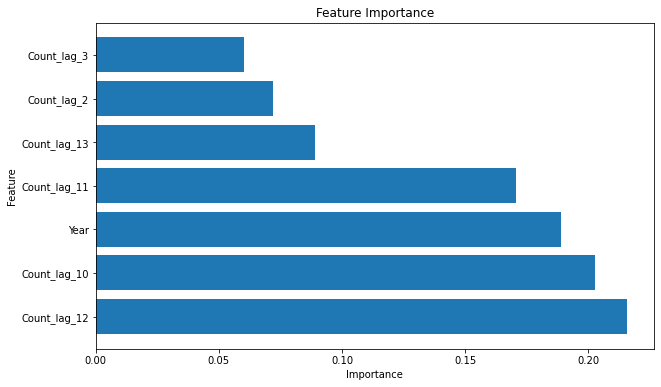

In [16]:
import matplotlib.pyplot as plt

# Get the feature importance scores from the trained XGBoost model
feature_importance = xgb_model.feature_importances_

# Get the names of the features
feature_names = features.columns

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


In [34]:
# Remove the "Month" and "Count" columns from the prediction_df based on selected features
prediction_data = prediction_df[selected_features]

# Use the trained XGBoost model to make predictions on the new data
predictions = xgb_model.predict(prediction_data)

# Add the predictions to the prediction_df DataFrame
prediction_df["Predicted_Count"] = predictions

# Print the updated prediction_df DataFrame with predictions
prediction_df

C:\Users\20211576\AppData\Local\Temp/ipykernel_21604/262282536.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df["Predicted_Count"] = predictions


,Year,Month,Count,Count_lag_1,Count_lag_2,Count_lag_3,Count_lag_4,Count_lag_5,Count_lag_6,Count_lag_7,Count_lag_8,Count_lag_9,Count_lag_10,Count_lag_11,Count_lag_12,Count_lag_13,Count_lag_14,Count_lag_15,Predicted_Count
120,2022,5,218,171.0,218.0,202.0,243.0,199.0,219.0,213.0,178.0,165.0,155.0,187.0,151.0,202.0,272.0,185.0,198.838364
121,2022,6,195,218.0,171.0,218.0,202.0,243.0,199.0,219.0,213.0,178.0,165.0,155.0,187.0,151.0,202.0,272.0,161.093567
122,2022,7,190,195.0,218.0,171.0,218.0,202.0,243.0,199.0,219.0,213.0,178.0,165.0,155.0,187.0,151.0,202.0,198.282928
123,2022,8,171,190.0,195.0,218.0,171.0,218.0,202.0,243.0,199.0,219.0,213.0,178.0,165.0,155.0,187.0,151.0,181.753326
124,2022,9,189,171.0,190.0,195.0,218.0,171.0,218.0,202.0,243.0,199.0,219.0,213.0,178.0,165.0,155.0,187.0,176.015732
125,2022,10,248,189.0,171.0,190.0,195.0,218.0,171.0,218.0,202.0,243.0,199.0,219.0,213.0,178.0,165.0,155.0,194.522308
126,2022,11,246,248.0,189.0,171.0,190.0,195.0,218.0,171.0,218.0,202.0,243.0,199.0,219.0,213.0,178.0,165.0,225.040451
127,2022,12,228,246.0,248.0,189.0,171.0,190.0,195.0,218.0,171.0,218.0,202.0,243.0,199.0,219.0,213.0,178.0,206.334915
128,2023,1,242,228.0,246.0,248.0,189.0,171.0,190.0,195.0,218.0,171.0,218.0,202.0,243.0,199.0,219.0,213.0,219.283203
129,2023,2,199,242.0,228.0,246.0,248.0,189.0,171.0,190.0,195.0,218.0,171.0,218.0,202.0,243.0,199.0,219.0,188.305359


In [35]:
# Remove the "Month" and "Count" columns from the prediction_df based on selected features
prediction_data = future_prediction[selected_features]

# Use the trained XGBoost model to make predictions on the new data
predictions = xgb_model.predict(prediction_data)

# Add the predictions to the prediction_df DataFrame
future_prediction["Predicted_Count"] = predictions

# Print the updated prediction_df DataFrame with predictions
future_prediction

C:\Users\20211576\AppData\Local\Temp/ipykernel_21604/1740741718.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_prediction["Predicted_Count"] = predictions


,Year,Month,Count,Count_lag_1,Count_lag_2,Count_lag_3,Count_lag_4,Count_lag_5,Count_lag_6,Count_lag_7,Count_lag_8,Count_lag_9,Count_lag_10,Count_lag_11,Count_lag_12,Count_lag_13,Count_lag_14,Count_lag_15,Predicted_Count
131,2023,4,0,231.0,199.0,242.0,228.0,246.0,248.0,189.0,171.0,190.0,195.0,218.0,171.0,218.0,202.0,243.0,199.631119
132,2023,5,0,0.0,231.0,199.0,242.0,228.0,246.0,248.0,189.0,171.0,190.0,195.0,218.0,171.0,218.0,202.0,181.793488


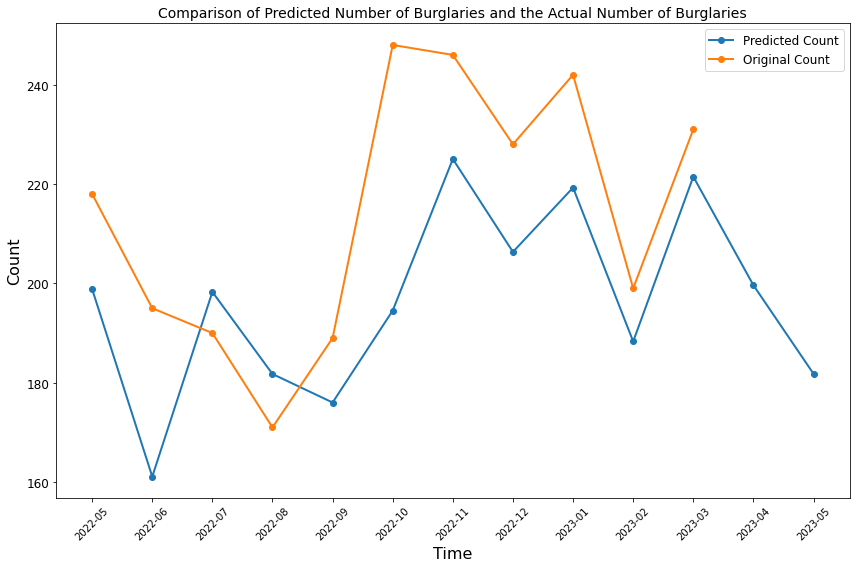

In [36]:
import matplotlib.pyplot as plt

# Concatenate the sum_df DataFrame with the future_sum_df DataFrame
combined_df = pd.concat([prediction_df, future_prediction])

# Reset the index to convert the grouped columns into separate columns
combined_df.reset_index(inplace=True)

# Convert 'Year' and 'Month' columns to string type
combined_df['Year'] = combined_df['Year'].astype(str)
combined_df['Month'] = combined_df['Month'].astype(str)

# Plot the line plot
plt.figure(figsize=(12, 8))  # Increase the figure size
plt.plot(combined_df.index, combined_df['Predicted_Count'], marker='o', label='Predicted Count', linewidth=2)  # Increase line thickness
plt.plot(combined_df.head(11).index, combined_df['Count'].head(11), marker='o', label='Original Count', linewidth=2)  # Increase line thickness
plt.xlabel('Time', fontsize=16)  # Increase font size
plt.ylabel('Count', fontsize=16)  # Increase font size
plt.title('Comparison of Predicted Number of Burglaries and the Actual Number of Burglaries', fontsize=14)  # Increase font size
plt.xticks(combined_df.index, ['2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04', '2023-05'], rotation=45, fontsize=10)  # Increase tick font size
plt.yticks(fontsize=12)  # Increase tick font size
plt.legend(fontsize=12)  # Increase legend font size
plt.tight_layout()
plt.show()

In [ ]:
# # Group by 'LSOA name' and count the number of crimes
# crime_counts = Barnet_df.groupby('LSOA name').size().reset_index(name='Crime Count')

# crime_counts

In [ ]:
# # Sort the crime counts in descending order
# crime_counts_sorted = crime_counts.sort_values('Crime Count', ascending=False)

# # Plot the crime counts
# plt.figure(figsize=(12, 6))
# plt.bar(crime_counts_sorted['LSOA name'].head(10), crime_counts_sorted['Crime Count'].head(10))
# plt.xticks(rotation=90)
# plt.xlabel('LSOA name')
# plt.ylabel('Crime Count')
# plt.title('Number of Crimes in Each LSOA for the highest 10')
# plt.show()

In [ ]:
# # Group by "LSOA name", "Month", and "Year" and count the occurrences of each category
# grouped_df = Barnet_df.groupby(['LSOA name', 'Month', 'Year']).size().reset_index(name='Count')

# grouped_df.head(5)

In [ ]:
# len(grouped_df)

In [ ]:
# # Set the figure size
# fig, ax = plt.subplots(figsize=(10, 6))

# # Plot the histogram of the "Count" column with thicker bars
# sns.histplot(data=grouped_df, x='Count', ax=ax, linewidth=2)

# # Set the title and labels with increased font size
# ax.set_title('Distribution of Count', fontsize=16)
# ax.set_xlabel('Count', fontsize=14)
# ax.set_ylabel('Frequency', fontsize=14)

# # Increase the font size of tick labels
# ax.tick_params(axis='both', labelsize=12)

# # Show the plot
# plt.show()

In [ ]:
# Create a MultiIndex from the existing columns 'LSOA name', 'Month', and 'Year'
grouped_df.set_index(['LSOA name', 'Month', 'Year'], inplace=True)

# Create a new MultiIndex with all possible combinations of 'LSOA name', 'Month', and 'Year'
all_lsoas = grouped_df.index.get_level_values('LSOA name').unique()
all_months = range(1, 13)  # Assuming months range from 1 to 12
all_years = grouped_df.index.get_level_values('Year').unique()
new_index = pd.MultiIndex.from_product([all_lsoas, all_months, all_years], names=['LSOA name', 'Month', 'Year'])

# Reindex the DataFrame with the new index, filling missing values with 0
grouped_df = grouped_df.reindex(new_index, fill_value=0).reset_index()

# Drop rows with year before 2010 or year 2023 and months after 3 (excluding December 2010)
grouped_df = grouped_df.loc[~(((grouped_df['Year'] == 2010) & (grouped_df['Month'] < 12)) | ((grouped_df['Year'] == 2023) & (grouped_df['Month'] > 4)))]

In [ ]:
# Sort the DataFrame by LSOA name, month, and year
grouped_df.sort_values(['LSOA name', 'Year', 'Month'], inplace=True)

# Fill NaN values in the 'Count' column with 0
grouped_df['Count'].fillna(0, inplace=True)

# Create columns for the past 12 lags
for lag in range(1, 16):
    grouped_df[f'Count Lag {lag}'] = grouped_df.groupby(['LSOA name'])['Count'].shift(lag)

# Fill NaN values in the lag columns with 0
grouped_df.iloc[:, -15:] = grouped_df.iloc[:, -15:].fillna(0)

# Reset the index if needed
grouped_df.reset_index(drop=True, inplace=True)

In [ ]:
grouped_df.iloc[110:160]

In [ ]:
prediction_df = grouped_df[((grouped_df['Year'] == 2023) & (grouped_df['Month'].isin([3, 2, 1]))) | ((grouped_df['Year'] == 2022) & (grouped_df['Month'].isin([12])))]
prediction_df

In [ ]:
future_prediction =  grouped_df[(grouped_df['Year'] == 2023) & (grouped_df['Month'].isin([4]))]
future_prediction 

In [ ]:
grouped_df = grouped_df.drop(prediction_df.index)
grouped_df = grouped_df.drop(future_prediction.index)

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

all_features =      [
                    'LSOA name', 'Count Lag 1', 'Count Lag 2', 'Count Lag 3', 'Count Lag 4',
                    'Count Lag 5', 'Count Lag 6', 'Count Lag 7', 'Count Lag 8', 'Count Lag 9',
                    'Count Lag 10', 'Count Lag 11', 'Count Lag 12', 'Count Lag 13', 'Count Lag 14',
                    'Count Lag 15', 'Year'
                    ]

# Choose the desired features
selected_features = [
                    'LSOA name', 'Count Lag 1', 'Count Lag 2', 'Count Lag 3', 'Count Lag 12', 'Count Lag 13', 'Count Lag 14',
                    'Count Lag 15', 'Year'
                    ]

# Select the desired features from the grouped_df DataFrame
selected_df = grouped_df[['Count'] + selected_features]

# Convert categorical features using one-hot encoding
X_encoded = pd.get_dummies(selected_df.drop('Count', axis=1))

# Prepare the dataset
y = selected_df['Count']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Define the XGBoost model with L1 regularization (Lasso)
#xgb_model = xgb.XGBRegressor(reg_alpha=0.1)  # Set the regularization strength with reg_alpha
xgb_model = xgb.XGBRegressor(reg_lambda=0.)  
# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print("Root Mean Squared Error (RMSE):", rmse)

In [ ]:
# Make predictions using the trained model on predict_2023_3
encoded_prediction = pd.get_dummies(prediction_df[selected_features])
y_prediction = xgb_model.predict(encoded_prediction)

# Round the predicted values to the nearest integer
#y_prediction = y_prediction.round()

# Create a DataFrame to store the predictions
prediction_df = pd.DataFrame({
    'LSOA name': prediction_df['LSOA name'],
    'Year': prediction_df['Year'],
    'Month': prediction_df['Month'],
    'Original Count': prediction_df['Count'],
    'Predicted Count': y_prediction
})

# Print the predictions
prediction_df.head(50)

In [ ]:
prediction_df[prediction_df['Original Count'] ==  prediction_df['Predicted Count']].head(20)

In [ ]:
sum(prediction_df['Original Count']), sum(prediction_df['Predicted Count'])

In [ ]:
from sklearn.metrics import confusion_matrix

# Convert the "Predicted Count" and "Original Count" columns to integers
y_pred_int = y_prediction.astype(int)
y_actual_int = prediction_df['Original Count'].astype(int)

# Create the confusion matrix
cm = confusion_matrix(y_actual_int, y_pred_int)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Set the labels and title
plt.xlabel("Predicted Count")
plt.ylabel("Original Count")
plt.title("Confusion Matrix")

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Get feature importance
importance = xgb_model.feature_importances_
feature_names = X_encoded.columns

# Exclude one-hot encoded columns
original_feature_names = [name for name in feature_names if not name.startswith('LSOA name_')]
original_importance = [importance[idx] for idx, name in enumerate(feature_names) if not name.startswith('LSOA name_')]

# Sort feature importance in descending order
sorted_idx = np.argsort(original_importance)[::-1]
sorted_features = np.array(original_feature_names)[sorted_idx]
sorted_importance = np.array(original_importance)[sorted_idx]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_features)), sorted_importance, align='center')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance (Excluding One-Hot Encoded Columns)')
plt.show()




In [ ]:
# Make predictions using the trained model on predict_2023_3
encoded_prediction = pd.get_dummies(future_prediction[selected_features])
y_prediction = xgb_model.predict(encoded_prediction)

# Round the predicted values to the nearest integer
#y_prediction = y_prediction.round()

# Create a DataFrame to store the predictions
future_prediction = pd.DataFrame({
    'LSOA name': future_prediction['LSOA name'],
    'Year': future_prediction['Year'],
    'Month': future_prediction['Month'],
    'Original Count': future_prediction['Count'],
    'Predicted Count': y_prediction
})

# Print the predictions
future_prediction.head(50)

In [ ]:
# Group the prediction_df DataFrame by Year and Month and calculate the sum of 'Predicted Count' and 'Original Count'
sum_df = prediction_df.groupby(['Year', 'Month']).sum()[['Predicted Count', 'Original Count']]

# Reset the index to convert the grouped columns into separate columns
sum_df.reset_index(inplace=True)

# Plot the line plot
plt.figure(figsize=(10, 6))
plt.plot(sum_df.index, sum_df['Predicted Count'], marker='o', label='Predicted Count')
plt.plot(sum_df.index, sum_df['Original Count'], marker='o', label='Original Count')
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Comparison of Predicted Count and Original Count')
plt.xticks(sum_df.index, [f"{year}-{month:02d}" for year, month in zip(sum_df['Year'], sum_df['Month'])], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Group the prediction_df DataFrame by Year and Month and calculate the sum of 'Predicted Count' and 'Original Count'
sum_df = prediction_df.groupby(['Year', 'Month']).sum()[['Predicted Count', 'Original Count']]

# Reset the index to convert the grouped columns into separate columns
sum_df.reset_index(inplace=True)

# Convert the 'Predicted Count' and 'Original Count' columns to numeric data type
sum_df['Predicted Count'] = sum_df['Predicted Count'].astype(float)
sum_df['Original Count'] = sum_df['Original Count'].astype(float)

# Group the future_prediction DataFrame by Year and Month and calculate the sum of 'Predicted Count'
future_sum_df = future_prediction.groupby(['Year', 'Month']).sum()[['Predicted Count']]

# Concatenate the sum_df DataFrame with the future_sum_df DataFrame
combined_df = pd.concat([sum_df, future_sum_df])

# Reset the index to convert the grouped columns into separate columns
combined_df.reset_index(inplace=True)

# Convert 'Year' and 'Month' columns to string type
combined_df['Year'] = combined_df['Year'].astype(str)
combined_df['Month'] = combined_df['Month'].astype(str)

# Plot the line plot
plt.figure(figsize=(12, 8))  # Increase the figure size
plt.plot(combined_df.index, combined_df['Predicted Count'], marker='o', label='Predicted Count', linewidth=2)  # Increase line thickness
plt.plot(sum_df.index, sum_df['Original Count'], marker='o', label='Original Count', linewidth=2)  # Increase line thickness
plt.xlabel('Time', fontsize=16)  # Increase font size
plt.ylabel('Count', fontsize=16)  # Increase font size
plt.title('Comparison of Predicted number of burglaries and the Actual number of burglaries', fontsize=14)  # Increase font size
plt.xticks(combined_df.index, ['2022-12', '2023-01', '2023-02', '2023-03', '2023-04'], rotation=45, fontsize=10)  # Increase tick font size
plt.yticks(fontsize=12)  # Increase tick font size
plt.legend(fontsize=12)  # Increase legend font size
plt.tight_layout()
plt.show()
